In [1]:
import sys 
from pathlib import Path

#Add the project root to the Python path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import matplotlib.pyplot as plt

from src.features import add_returns, add_mean_reversion_signal, add_momentum_signal, add_vol_regime
from src.data import fetch_yahoo
from src.backtest import backtest_from_signal
from src.metrics import summary
from src.metrics import regime_summary

In [2]:
start, end = "2016-01-01", "2026-01-01"

us = fetch_yahoo("SPY", start, end)
tw = fetch_yahoo("2330.TW", start, end)

us.head(), us.tail(), us.isna().sum()


(                  Open        High         Low       Close     Volume
 Date                                                                 
 2016-01-04  169.923028  170.380694  168.312697  170.372223  222353500
 2016-01-05  170.694250  171.118020  169.550081  170.660355  110845800
 2016-01-06  168.100771  169.558538  167.473601  168.507599  152112600
 2016-01-07  165.549692  167.337999  164.074970  164.464844  213436100
 2016-01-08  165.431046  165.990425  162.371432  162.659592  209817200,
                   Open        High         Low       Close    Volume
 Date                                                                
 2025-12-24  687.950012  690.830017  687.799988  690.380005  39445600
 2025-12-26  690.640015  691.659973  689.270020  690.309998  41613300
 2025-12-29  687.539978  689.200012  686.070007  687.849976  62559500
 2025-12-30  687.450012  688.559998  686.580017  687.010010  47160700
 2025-12-31  687.140015  687.359985  681.710022  681.919983  74144800,
 Open      

In [3]:
tw.head(), tw.tail(), tw.isna().sum()

(                  Open        High         Low       Close    Volume
 Date                                                                
 2016-01-04  108.171054  108.930149  105.514221  105.893768  39169000
 2016-01-05  105.514237  106.273333  103.996047  104.755142  46381000
 2016-01-06  104.755121  104.755121  102.477836  102.857384  53617000
 2016-01-07  102.098291  102.477838   99.061910  100.959648  62539000
 2016-01-08  100.200582  102.477868  100.200582  101.718773  50123000,
               Open    High     Low   Close    Volume
 Date                                                
 2025-12-24  1495.0  1500.0  1485.0  1495.0  12987261
 2025-12-26  1505.0  1510.0  1495.0  1510.0  18823612
 2025-12-29  1515.0  1530.0  1510.0  1530.0  21124648
 2025-12-30  1515.0  1530.0  1510.0  1520.0  20325400
 2025-12-31  1520.0  1550.0  1515.0  1550.0  29695967,
 Open      0
 High      0
 Low       0
 Close     0
 Volume    0
 dtype: int64)

MOM:  {'sharpe': -0.8823936728824134, 'max_drawdown': -0.8587607839051613, 'AnnRet(approx)': -0.15867989738197885, 'AvgTurnover': 0.7052505966587113}
MR:  {'sharpe': -0.22227767453266034, 'max_drawdown': -0.5917505874501189, 'AnnRet(approx)': -0.05432803416136889, 'AvgTurnover': 0.1913285600636436}
MOM regime: {'regime=0': {'sharpe': -1.240604800700344, 'max_drawdown': -0.8580605758825384, 'AnnRet(approx)': -0.20997444238244434, 'AvgTurnover': 0.6538252848616386}, 'regime=1': {'sharpe': -0.6801869911030148, 'max_drawdown': -0.8065495587361762, 'AnnRet(approx)': -0.48125470031998785, 'AvgTurnover': 0.8477611940298507}}
MR  regime: {'regime=0': {'sharpe': -0.6783273854643559, 'max_drawdown': -0.5846685700966773, 'AnnRet(approx)': -0.0733662503831547, 'AvgTurnover': 0.17525773195876287}, 'regime=1': {'sharpe': 0.24639143943068895, 'max_drawdown': -0.5747948919869592, 'AnnRet(approx)': -0.19696133458253617, 'AvgTurnover': 0.23582089552238805}}


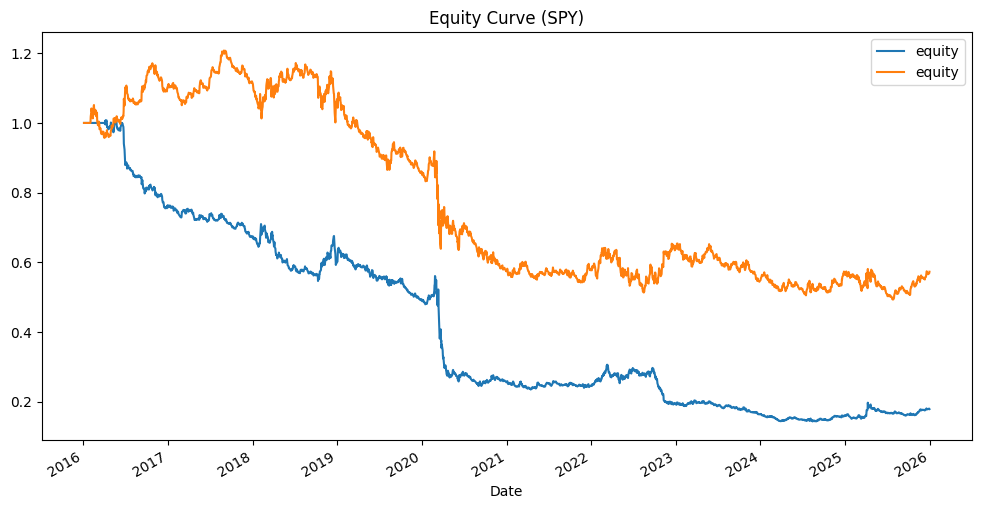

In [4]:
df = us
df = add_returns(df)
df = add_momentum_signal(df, lookback=60)
df = add_mean_reversion_signal(df, z_window=20)
df = add_vol_regime(df, vol_window=20, q=0.7)

bt_mom = backtest_from_signal(df, "signal_mom", fee_bps=1.0)
bt_mr = backtest_from_signal(df, "signal_mr", fee_bps=1.0)


print("MOM: ", summary(bt_mom))
print("MR: ", summary(bt_mr))
print("MOM regime:", regime_summary(bt_mom))
print("MR  regime:", regime_summary(bt_mr))


plt.figure(figsize=(12, 6))
bt_mom["equity"].plot()
bt_mr["equity"].plot()
plt.legend()
plt.title("Equity Curve (SPY)")
plt.show()

MOM:  {'sharpe': -0.5958755965414197, 'max_drawdown': -0.8673994890663783, 'AnnRet(approx)': -0.17647423849916866, 'AvgTurnover': 0.7345679012345679}
MR:  {'sharpe': -0.4494983112317114, 'max_drawdown': -0.8588817600963912, 'AnnRet(approx)': -0.1445921922553287, 'AvgTurnover': 0.2374485596707819}
MOM regime: {'regime=0': {'sharpe': -0.734944214774115, 'max_drawdown': -0.8673994890663783, 'AnnRet(approx)': -0.2456100050683323, 'AvgTurnover': 0.7246117084826762}, 'regime=1': {'sharpe': -0.4571510676558978, 'max_drawdown': -0.7917729118833592, 'AnnRet(approx)': -0.44848611569942176, 'AvgTurnover': 0.7576158940397351}}
MR  regime: {'regime=0': {'sharpe': -0.8573257493674293, 'max_drawdown': -0.857541851694736, 'AnnRet(approx)': -0.20284686867634194, 'AvgTurnover': 0.24790919952210275}, 'regime=1': {'sharpe': 0.061464617607168835, 'max_drawdown': -0.8578554436131627, 'AnnRet(approx)': -0.38829371735470886, 'AvgTurnover': 0.21456953642384105}}


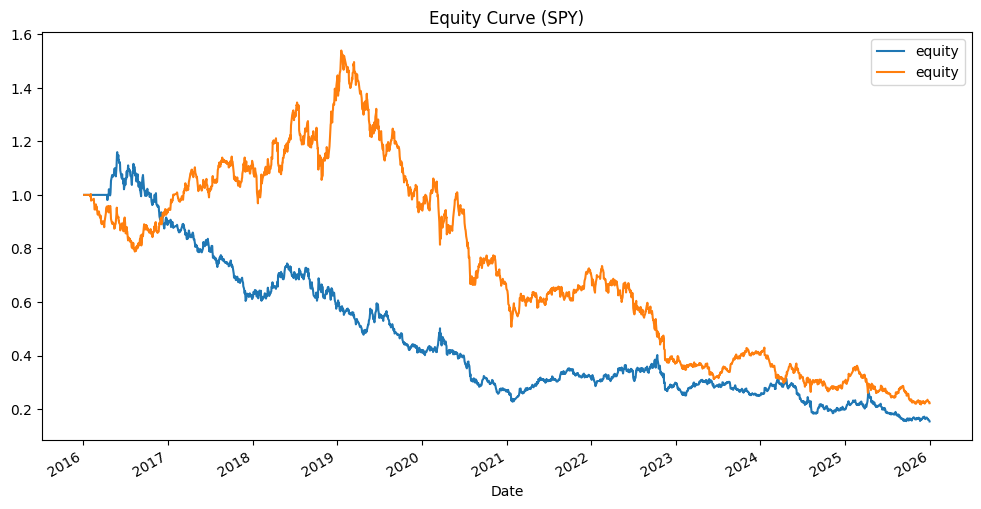

In [5]:
df = tw
df = add_returns(df)
df = add_momentum_signal(df, lookback=60)
df = add_mean_reversion_signal(df, z_window=20)
df = add_vol_regime(df, vol_window=20, q=0.7)

bt_mom = backtest_from_signal(df, "signal_mom", fee_bps=1.0)
bt_mr = backtest_from_signal(df, "signal_mr", fee_bps=1.0)


print("MOM: ", summary(bt_mom))
print("MR: ", summary(bt_mr))
print("MOM regime:", regime_summary(bt_mom))
print("MR  regime:", regime_summary(bt_mr))


plt.figure(figsize=(12, 6))
bt_mom["equity"].plot()
bt_mr["equity"].plot()
plt.legend()
plt.title("Equity Curve (SPY)")
plt.show()

SPY MOM: {'sharpe': -0.8823936728824134, 'max_drawdown': -0.8587607839051613, 'AnnRet(approx)': -0.15867989738197885, 'AvgTurnover': 0.7052505966587113}
SPY MR : {'sharpe': -0.22227767453266034, 'max_drawdown': -0.5917505874501189, 'AnnRet(approx)': -0.05432803416136889, 'AvgTurnover': 0.1913285600636436}
2330.TW MOM: {'sharpe': -0.5958755965414197, 'max_drawdown': -0.8673994890663783, 'AnnRet(approx)': -0.17647423849916866, 'AvgTurnover': 0.7345679012345679}
2330.TW MR : {'sharpe': -0.4494983112317114, 'max_drawdown': -0.8588817600963912, 'AnnRet(approx)': -0.1445921922553287, 'AvgTurnover': 0.2374485596707819}


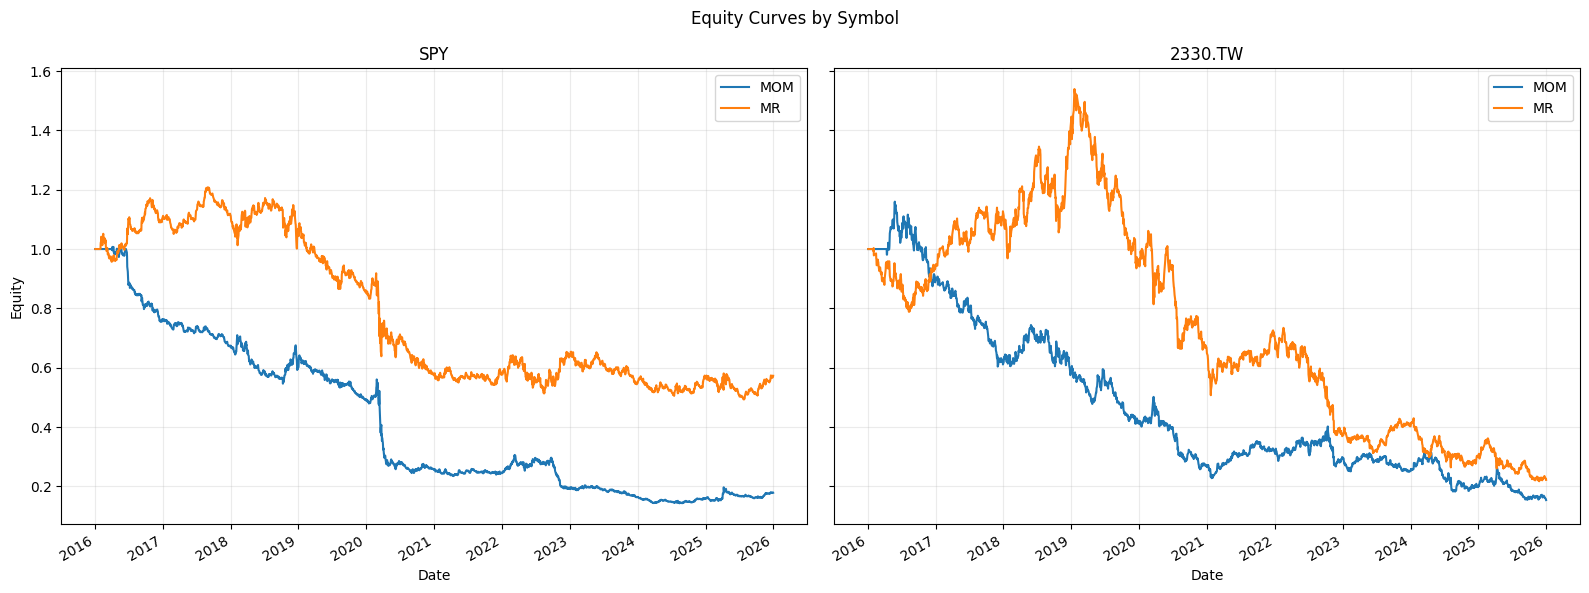

In [7]:
def run(symbol):
    df = fetch_yahoo(symbol, start, end)
    df = add_returns(df)
    df = add_momentum_signal(df, lookback=60)
    df = add_mean_reversion_signal(df, z_window=20)
    df = add_vol_regime(df, vol_window=20, q=0.7)

    bt_mom = backtest_from_signal(df, "signal_mom", fee_bps=1.0)
    bt_mr = backtest_from_signal(df, "signal_mr", fee_bps=1.0)

    return df, bt_mom, bt_mr

symbols = ["SPY", "2330.TW"]
results = {}

for sym in symbols:
    df, bt_mom, bt_mr = run(sym)
    results[sym] = {"mom": bt_mom, "mr": bt_mr}
    print(sym, "MOM:", summary(bt_mom))
    print(sym, "MR :", summary(bt_mr))

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for ax, sym in zip(axes, symbols):
    results[sym]["mom"]["equity"].plot(ax=ax, label="MOM")
    results[sym]["mr"]["equity"].plot(ax=ax, label="MR")
    ax.set_title(sym)
    ax.set_xlabel("Date")
    ax.set_ylabel("Equity")
    ax.grid(alpha=0.25)
    ax.legend()

plt.suptitle("Equity Curves by Symbol")
plt.tight_layout()
plt.show()

In [8]:
for sym in ["SPY", "2330.TW"]:
    df, bt_mom, bt_mr = run(sym)
    print(sym, "MOM regime: ", regime_summary(bt_mom))
    print(sym, "MR  regime: ", regime_summary(bt_mr))

SPY MOM regime:  {'regime=0': {'sharpe': -1.240604800700344, 'max_drawdown': -0.8580605758825384, 'AnnRet(approx)': -0.20997444238244434, 'AvgTurnover': 0.6538252848616386}, 'regime=1': {'sharpe': -0.6801869911030148, 'max_drawdown': -0.8065495587361762, 'AnnRet(approx)': -0.48125470031998785, 'AvgTurnover': 0.8477611940298507}}
SPY MR  regime:  {'regime=0': {'sharpe': -0.6783273854643559, 'max_drawdown': -0.5846685700966773, 'AnnRet(approx)': -0.0733662503831547, 'AvgTurnover': 0.17525773195876287}, 'regime=1': {'sharpe': 0.24639143943068895, 'max_drawdown': -0.5747948919869592, 'AnnRet(approx)': -0.19696133458253617, 'AvgTurnover': 0.23582089552238805}}
2330.TW MOM regime:  {'regime=0': {'sharpe': -0.734944214774115, 'max_drawdown': -0.8673994890663783, 'AnnRet(approx)': -0.2456100050683323, 'AvgTurnover': 0.7246117084826762}, 'regime=1': {'sharpe': -0.4571510676558978, 'max_drawdown': -0.7917729118833592, 'AnnRet(approx)': -0.44848611569942176, 'AvgTurnover': 0.7576158940397351}}
23